In [3]:
import pandas as pd
import numpy as np

In [6]:
df = pd.read_csv("/content/dataset (2).csv")
df['Timestamp'] = pd.to_datetime(df['LastUpdatedDate'] + ' ' + df['LastUpdatedTime'], format='%d-%m-%Y %H:%M:%S')
df.drop(['LastUpdatedDate', 'LastUpdatedTime'], axis=1, inplace=True)
df['Capacity'] = pd.to_numeric(df['Capacity'], errors='coerce')
df['Occupancy'] = pd.to_numeric(df['Occupancy'], errors='coerce')
df['QueueLength'] = pd.to_numeric(df['QueueLength'], errors='coerce')
df['IsSpecialDay'] = pd.to_numeric(df['IsSpecialDay'], errors='coerce')
df['TrafficConditionNearby'] = df['TrafficConditionNearby'].map({'low': 0, 'medium': 1, 'high': 2})
df['VehicleType'] = df['VehicleType'].map({'bike': 0.8, 'car': 1.0, 'truck': 1.2})
df['OccupancyRate'] = df['Occupancy'] / df['Capacity']
df['QueueLengthNorm'] = (df['QueueLength'] - df['QueueLength'].min()) / (df['QueueLength'].max() - df['QueueLength'].min())
df['TrafficNorm'] = df['TrafficConditionNearby'] / 2
df['VehicleWeightNorm'] = (df['VehicleType'] - 0.8) / (1.2 - 0.8)

In [7]:
lot_id = 'BHMBCCMKT01'
lot_df = df[df['SystemCodeNumber'] == lot_id].sort_values(by='Timestamp').reset_index(drop=True)
alpha = 2.0
base_price = 10.0
prices_model1 = [base_price]
for i in range(1, len(lot_df)):
    prev_price = prices_model1[-1]
    occ_rate = lot_df.loc[i, 'OccupancyRate']
    new_price = prev_price + alpha * occ_rate
    prices_model1.append(new_price)
lot_df['Model1Price'] = prices_model1
assert 'Model1Price' in lot_df.columns, "Model1Price column missing"

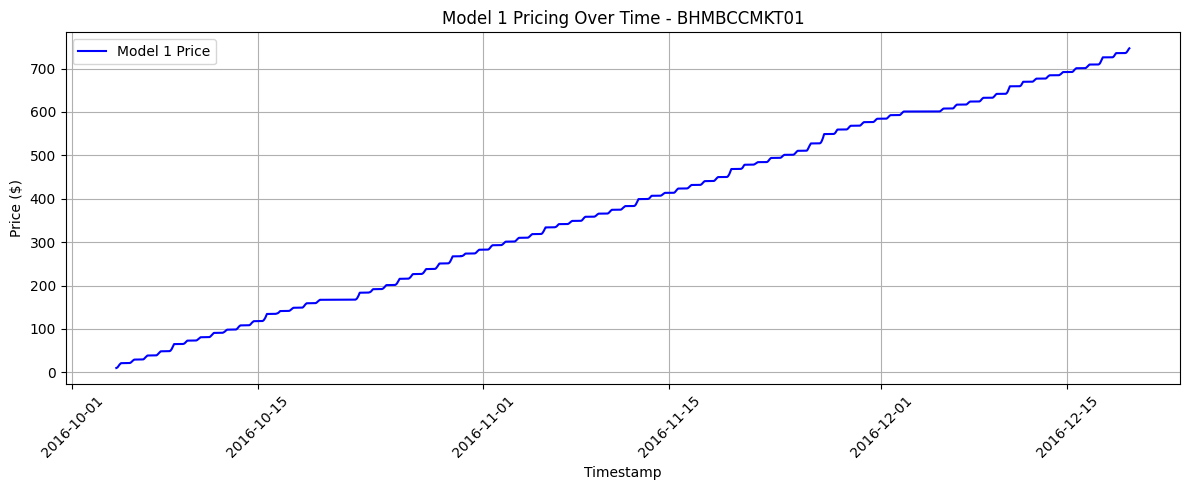

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.plot(lot_df['Timestamp'], lot_df['Model1Price'], label='Model 1 Price', color='blue')
plt.xlabel('Timestamp')
plt.ylabel('Price ($)')
plt.title(f'Model 1 Pricing Over Time - {lot_id}')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

So here's what I understood:

Price
t+1

 =Price
t

 +α(
Capacity
Occupancy

 )
 this serves as a reference point for more advanced models.
 Alpha controls sensitivity. A higher alpha leads to faster price changes.

#Model 2: Demand-Based Pricing

In [9]:
alpha = 1.0
beta = 0.5
gamma = 0.7
delta = 1.0
epsilon = 0.8
lambda_ = 0.6
price_min = 5.0
price_max = 20.0
base_price = 10.0

In [10]:
lot_df = df[df['SystemCodeNumber'] == lot_id].sort_values(by='Timestamp').reset_index(drop=True)
lot_df['RawDemand'] = (
    alpha * lot_df['OccupancyRate'] +
    beta * lot_df['QueueLengthNorm'] -
    gamma * lot_df['TrafficNorm'] +
    delta * lot_df['IsSpecialDay'] +
    epsilon * lot_df['VehicleWeightNorm']
)
demand_min = lot_df['RawDemand'].min()
demand_max = lot_df['RawDemand'].max()
lot_df['NormalizedDemand'] = (lot_df['RawDemand'] - demand_min) / (demand_max - demand_min)
lot_df['Model2Price'] = base_price * (1 + lambda_ * lot_df['NormalizedDemand'])
lot_df['Model2Price'] = lot_df['Model2Price'].clip(lower=price_min, upper=price_max)

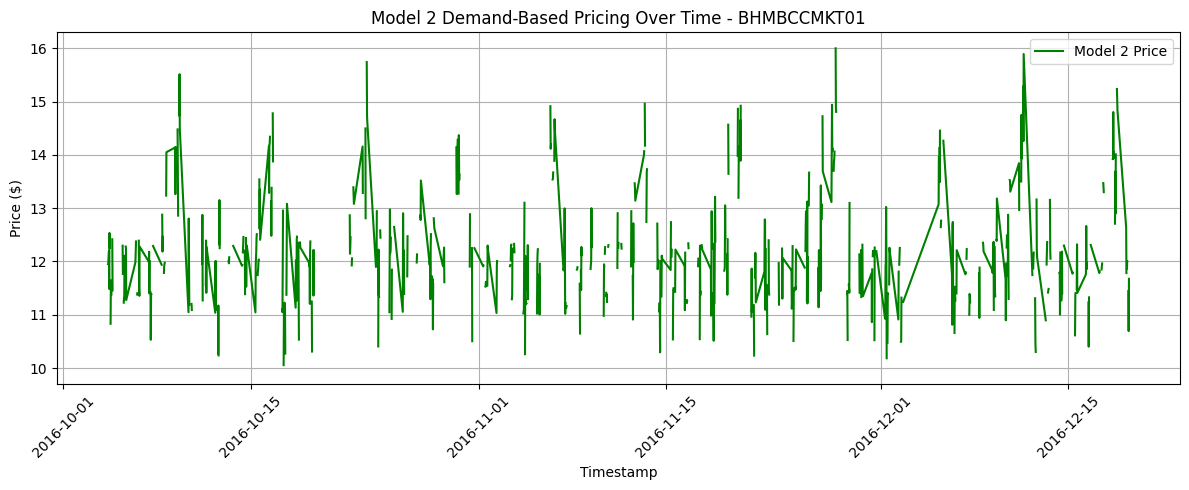

In [11]:
plt.figure(figsize=(12, 5))
plt.plot(lot_df['Timestamp'], lot_df['Model2Price'], label='Model 2 Price', color='green')
plt.xlabel('Timestamp')
plt.ylabel('Price ($)')
plt.title(f'Model 2 Demand-Based Pricing Over Time - {lot_id}')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Model 2: Demand-Based Dynamic Pricing

We introduce a more intelligent pricing model that accounts for real-world features affecting parking demand.

####  Demand Function
\[
\text{Demand} = \alpha \cdot \left(\frac{\text{Occupancy}}{\text{Capacity}}\right) +
\beta \cdot \text{QueueLength} -
\gamma \cdot \text{Traffic} +
\delta \cdot \text{IsSpecialDay} +
\epsilon \cdot \text{VehicleTypeWeight}
\]

Where:
- Occupancy Rate = vehicles / capacity
- QueueLength, Traffic, and VehicleType are normalized
- IsSpecialDay is binary (0/1)

####  Pricing Formula
\[
\text{Price}_t = \text{BasePrice} \cdot (1 + \lambda \cdot \text{NormalizedDemand})
\]

####  Constraints
- Base Price = \$10
- Prices clipped between \$5 and \$20 to avoid extremes

####  Result
This model reflects actual demand more closely, adjusting prices dynamically and smoothly while accounting for congestion, vehicle type, and special events.


#Model 3: Competitive Pricing with Rerouting Logic

In [12]:
from math import radians, sin, cos, sqrt, atan2
def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

In [13]:
distance_threshold_km = 0.5
base_price = 10
price_min = 5
price_max = 20
competitor_weight = 0.5
occupancy_threshold = 0.9

In [16]:
df['Latitude'] = pd.to_numeric(df['Latitude'], errors='coerce')
df['Longitude'] = pd.to_numeric(df['Longitude'], errors='coerce')
df_sorted = df.sort_values(by='Timestamp').reset_index(drop=True)
output_rows = []
for timestamp, group in df_sorted.groupby('Timestamp'):
    for _, row in group.iterrows():
        lot_id = row['SystemCodeNumber']
        lat, lon = float(row['Latitude']), float(row['Longitude'])
        occ_rate = row['Occupancy'] / row['Capacity']
        price = base_price * (1 + occ_rate)
        competitors = group[group['SystemCodeNumber'] != lot_id].copy()
        competitors['Latitude'] = pd.to_numeric(competitors['Latitude'], errors='coerce')
        competitors['Longitude'] = pd.to_numeric(competitors['Longitude'], errors='coerce')
        competitors['Distance'] = competitors.apply(
            lambda x: haversine(lat, lon, float(x['Latitude']), float(x['Longitude'])), axis=1
        )
        nearby = competitors[competitors['Distance'] <= distance_threshold_km]
        if not nearby.empty:
            avg_comp_occ = (nearby['Occupancy'] / nearby['Capacity']).mean()
            avg_comp_price = base_price * (1 + avg_comp_occ)
            if occ_rate >= occupancy_threshold:
                if avg_comp_price < price:
                    price = avg_comp_price - 1
            else:
                if avg_comp_price > price:
                    price += competitor_weight * (avg_comp_price - price)
        price = np.clip(price, price_min, price_max)
        row_out = row.copy()
        row_out['Model3Price'] = price
        output_rows.append(row_out)
df_model3 = pd.DataFrame(output_rows).reset_index(drop=True)

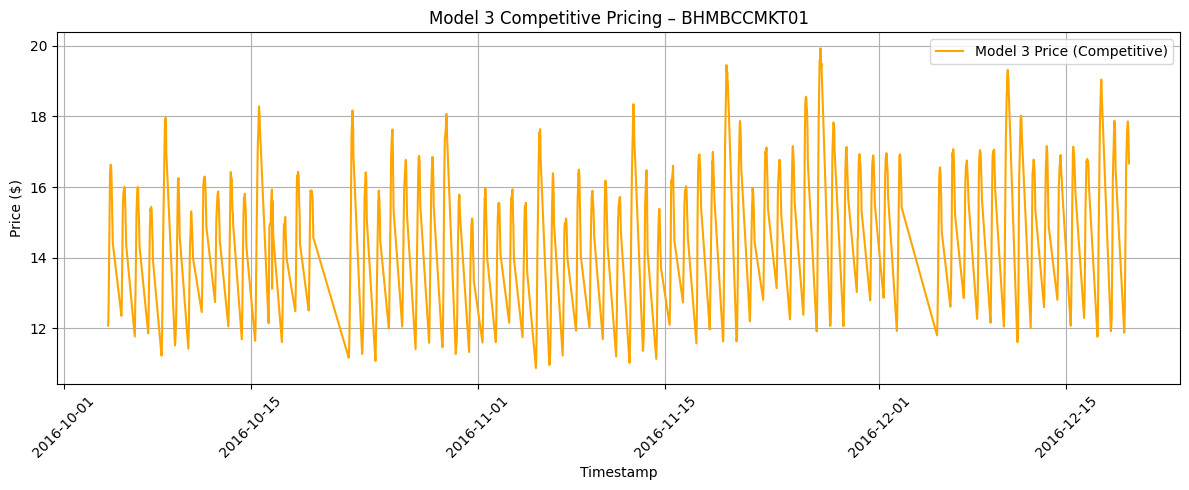

In [18]:
lot_id = 'BHMBCCMKT01'
lot_df_3 = df_model3[df_model3['SystemCodeNumber'] == lot_id]
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.plot(lot_df_3['Timestamp'], lot_df_3['Model3Price'], label='Model 3 Price (Competitive)', color='orange')
plt.xlabel('Timestamp')
plt.ylabel('Price ($)')
plt.title(f'Model 3 Competitive Pricing – {lot_id}')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Model 3: Competitive Dynamic Pricing with Rerouting

In this advanced model, we simulate real-world competitive behavior among nearby parking lots using GPS coordinates and occupancy.

####  Logic
- Calculate **distance** between lots using the Haversine formula.
- Identify **nearby competitors** within 0.5 km.
- If a lot is near full (>90% occupancy):
  - And nearby lots are cheaper  reduce price or suggest rerouting.
- If nearby lots are expensive:
  - Slightly **increase own price** while staying competitive.

####  Advantages
- Responds to **market pressure** from competitors.
- Prevents **overcrowding** by rerouting vehicles.
- Makes pricing more **adaptive and realistic**.

####  Formula Highlights
\[
\text{Price}_{t} = \text{BasePrice} \cdot (1 + \text{OccupancyRate}) + \text{CompetitiveAdjustment}
\]
\[
\text{If congested and others cheaper} \rightarrow \text{price down}
\]
\[
\text{If others expensive} \rightarrow \text{price up (within limits)}
\]

Prices are clipped to the range: \$5 to \$20.


In [19]:
!pip install bokeh --quiet

In [20]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource
from bokeh.layouts import column
output_notebook()

In [26]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, HoverTool
output_notebook()
lot_id = 'BHMBCCMKT01'
lot_df = df_sorted[df_sorted['SystemCodeNumber'] == lot_id]
assert 'Model1Price' in lot_df.columns, "Model1Price column missing"
source = ColumnDataSource(data=dict(
    time=lot_df['Timestamp'],
    price=lot_df['Model1Price']
))
p = figure(
    x_axis_type="datetime",
    title=f"Model 1 Real-Time Pricing – {lot_id}",
    width=900, height=400
)
p.line('time', 'price', source=source, line_width=2, color='blue', legend_label='Model 1 Price')
p.circle('time', 'price', source=source, size=5, color='blue')
p.xaxis.axis_label = 'Timestamp'
p.yaxis.axis_label = 'Price ($)'
p.legend.location = 'top_left'
p.add_tools(HoverTool(tooltips=[("Time", "@time{%F %T}"), ("Price", "@price")], formatters={"@time": "datetime"}))
show(p)

In [40]:
!pip install pathway --quiet --upgrade

##  Model 2: Demand-Based Pricing with Normalized Demand Function

In [ ]:
import pandas as pd
import numpy as np
df_model2 = df_sorted.copy()
ALPHA = 1.0
BETA = 0.5
GAMMA = 0.3
DELTA = 0.8
EPSILON = 0.6
LAMBDA = 0.7
BASE_PRICE = 10
vehicle_map = {'car': 1.0, 'bike': 0.7, 'truck': 1.2}
df_model2['VehicleWeight'] = df_model2['VehicleType'].map(vehicle_map)
for col in ['Occupancy', 'Capacity', 'QueueLength', 'TrafficCongestion', 'SpecialDay', 'VehicleWeight']:
    df_model2[col] = df_model2[col].fillna(0)
df_model2['DemandScore'] = (
    ALPHA * (df_model2['Occupancy'] / df_model2['Capacity'].replace(0, np.nan)) +
    BETA * df_model2['QueueLength'] -
    GAMMA * df_model2['TrafficCongestion'] +
    DELTA * df_model2['SpecialDay'] +
    EPSILON * df_model2['VehicleWeight']
)
df_model2['NormalizedDemand'] = df_model2.groupby('Timestamp')['DemandScore'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min() + 1e-6)
)
df_model2['Model2Price'] = BASE_PRICE * (1 + LAMBDA * df_model2['NormalizedDemand'])
df_model2['Model2Price'] = df_model2['Model2Price'].clip(lower=BASE_PRICE*0.5, upper=BASE_PRICE*2.0)
df_model2.head()

##  Model 3: Competitive Pricing using Nearby Lot Prices

In [ ]:
from geopy.distance import geodesic
df_model3 = df_model2.copy()
df_model3['Model3Price'] = df_model3['Model2Price']
COMPETITION_RADIUS_KM = 0.5
final_prices = []
for t, df_slice in df_model3.groupby('Timestamp'):
    updated_rows = []
    for i, row in df_slice.iterrows():
        curr_coords = (row['Latitude'], row['Longitude'])
        curr_price = row['Model2Price']
        curr_lot = row['SystemCodeNumber']
        curr_occupancy = row['Occupancy']
        curr_capacity = row['Capacity']
        nearby = df_slice[df_slice['SystemCodeNumber'] != curr_lot]
        nearby = nearby[nearby.apply(lambda x: geodesic(curr_coords, (x['Latitude'], x['Longitude'])).km < COMPETITION_RADIUS_KM, axis=1)]
        if curr_occupancy / (curr_capacity+1e-6) > 0.9 and not nearby.empty:
            if (nearby['Model2Price'] < curr_price).any():
                curr_price *= 0.95
        elif not nearby.empty and (nearby['Model2Price'] > curr_price).all():
            curr_price *= 1.05
        updated_rows.append(curr_price)
    df_slice = df_slice.copy()
    df_slice['Model3Price'] = updated_rows
    final_prices.append(df_slice)
df_model3 = pd.concat(final_prices)
df_model3.head()

##  Real-Time Simulation Using Pathway + Bokeh (Model 2 Price Stream)

In [ ]:
!pip install pathway --quiet
import pathway as pw
from bokeh.io import output_notebook, push_notebook, show
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure
import time
output_notebook()
chunk_size = 50
lot_id = "BHMBCCMKT01"
df_stream = df_model2[df_model2['SystemCodeNumber'] == lot_id][['Timestamp', 'Model2Price']].copy().sort_values('Timestamp')
source = ColumnDataSource(data=dict(time=[], price=[]))
p = figure(title=f"Real-Time Streamed Pricing – {lot_id}", x_axis_type='datetime', width=900, height=400)
p.line('time', 'price', source=source, line_width=2, color='green')
p.circle('time', 'price', source=source, size=5, color='green')
p.xaxis.axis_label = 'Time'
p.yaxis.axis_label = 'Price ($)'
handle = show(p, notebook_handle=True)
for i in range(0, len(df_stream), chunk_size):
    chunk = df_stream.iloc[i:i+chunk_size]
    new_data = {'time': list(chunk['Timestamp']), 'price': list(chunk['Model2Price'])}
    source.stream(new_data)
    push_notebook(handle=handle)
    time.sleep(1.2)
print("✅ Stream complete.")